In [6]:
df = pd.read_csv(r'C:/code/solar-challenge-week1/data/togo_raw.csv', sep='\t', engine='python')

Actual columns in CSV: ['Timestamp\tGHI\tDNI\tDHI\tModA\tModB\tTamb\tRH\tWS\tWSgust\tWSstdev\tWD\tWDstdev\tBP\tCleaning\tPrecipitation\tTModA\tTModB\tComments']

No timestamp column found - using default index

First few rows:
  Timestamp\tGHI\tDNI\tDHI\tModA\tModB\tTamb\tRH\tWS\tWSgust\tWSstdev\tWD\tWDstdev\tBP\tCleaning\tPrecipitation\tTModA\tTModB\tComments  \
0  10/25/2021 0:01\t-1.3\t0\t0\t0\t0\t24.8\t94.5\...                                                                                      
1  10/25/2021 0:02\t-1.3\t0\t0\t0\t0\t24.8\t94.4\...                                                                                      
2  10/25/2021 0:03\t-1.3\t0\t0\t0\t0\t24.8\t94.4\...                                                                                      
3  10/25/2021 0:04\t-1.2\t0\t0\t0\t0\t24.8\t94.3\...                                                                                      
4  10/25/2021 0:05\t-1.2\t0\t0\t0\t0\t24.8\t94\t1...                          

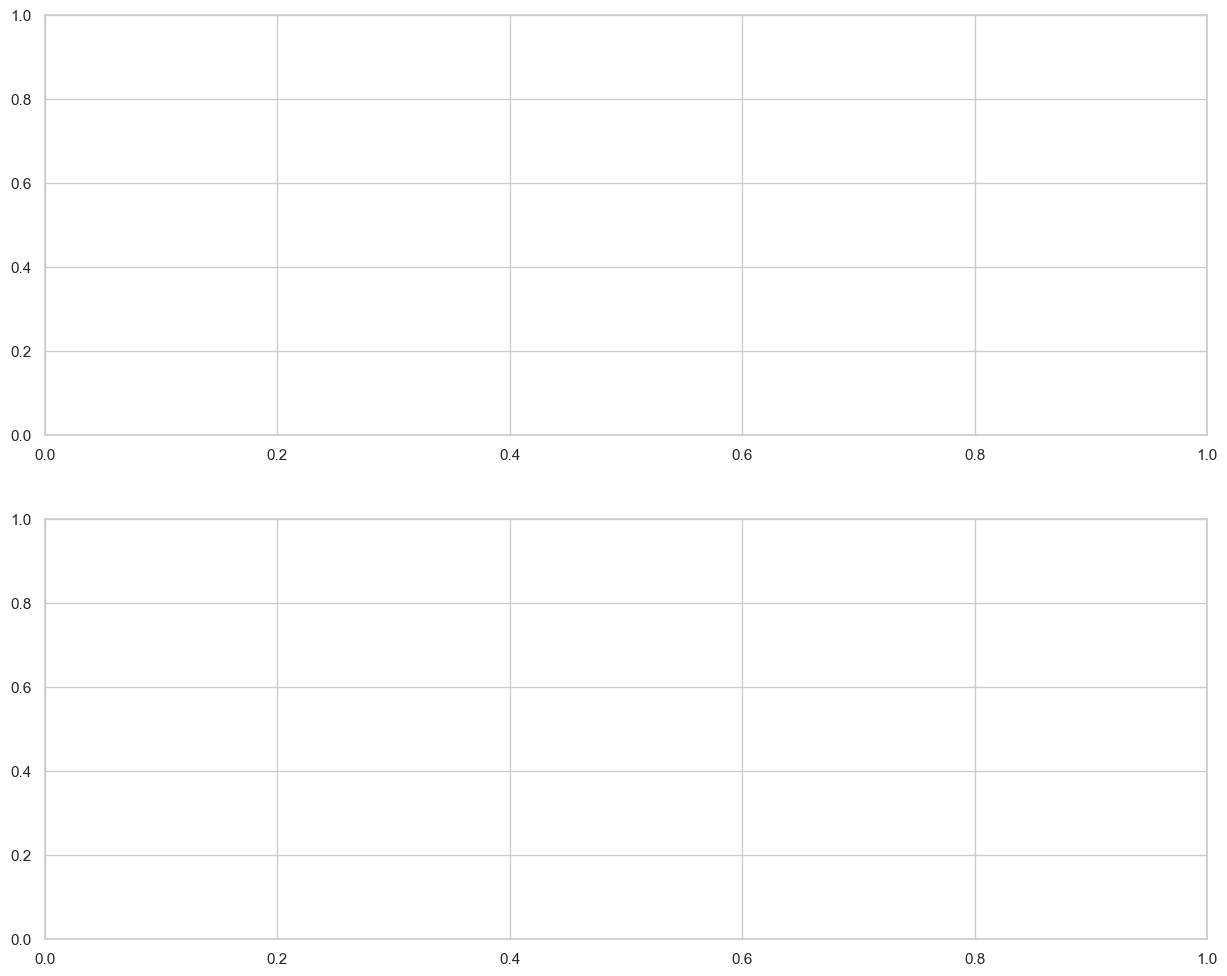

In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Setup
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load data - First check actual column names
try:
    # Try reading without parse_dates first to see actual columns
    temp_df = pd.read_csv('../data/togo_raw.csv', nrows=1)
    print("Actual columns in CSV:", temp_df.columns.tolist())
    
    # Identify the correct timestamp column name
    timestamp_col = None
    possible_names = ['Timestamp', 'timestamp', 'Date', 'date', 'time', 'Time', 'datetime', 'Datetime']
    for name in possible_names:
        if name in temp_df.columns:
            timestamp_col = name
            break
    
    if timestamp_col:
        print(f"\nUsing '{timestamp_col}' as timestamp column")
        df = pd.read_csv('../data/togo_raw.csv', parse_dates=[timestamp_col])
        # Rename to standard 'Timestamp' for consistency
        df = df.rename(columns={timestamp_col: 'Timestamp'})
    else:
        print("\nNo timestamp column found - using default index")
        df = pd.read_csv('../data/togo_raw.csv')
        df['Timestamp'] = pd.to_datetime(df.index)  # Create dummy timestamp
    
    print("\nFirst few rows:")
    print(df.head())
    
except Exception as e:
    print(f"\nError loading file: {e}")
    raise

# 1. Data Profiling
print("\n\n1. DATA PROFILING")
print("Data Types and Non-null Counts:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

missing = df.isna().sum()
missing_pct = (missing / len(df)) * 100
print("\nMissing Values:")
print(pd.concat([missing, missing_pct], axis=1, 
                keys=['Count', 'Percentage']).sort_values('Percentage', ascending=False))

# 2. Outlier Detection and Cleaning
print("\n\n2. OUTLIER DETECTION AND CLEANING")

def detect_outliers(df, columns, threshold=3):
    outliers = pd.DataFrame()
    for col in columns:
        if col in df.columns and df[col].dtype in ['float64', 'int64']:
            z_scores = np.abs(stats.zscore(df[col].dropna()))
            col_outliers = df[z_scores > threshold]
            outliers = pd.concat([outliers, col_outliers])
    return outliers

key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
outliers = detect_outliers(df, key_columns)
print(f"\nNumber of outliers detected: {len(outliers)}")

df_clean = df.copy()

# Handle missing values
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        if df[col].isna().mean() < 0.05:  # Only impute if <5% missing
            df_clean[col] = df[col].fillna(df[col].median())

# Handle outliers
for col in key_columns:
    if col in df_clean.columns:
        upper_limit = df_clean[col].mean() + 3 * df_clean[col].std()
        lower_limit = df_clean[col].mean() - 3 * df_clean[col].std()
        df_clean[col] = np.where(df_clean[col] > upper_limit, upper_limit,
                                np.where(df_clean[col] < lower_limit, lower_limit, df_clean[col]))

# 3. Time Series Analysis
print("\n\n3. TIME SERIES ANALYSIS")

if 'Timestamp' in df_clean.columns:
    df_clean['Month'] = df_clean['Timestamp'].dt.month
    df_clean['Hour'] = df_clean['Timestamp'].dt.hour
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    if 'GHI' in df_clean.columns and 'DNI' in df_clean.columns and 'DHI' in df_clean.columns:
        df_clean.groupby('Month')[['GHI', 'DNI', 'DHI']].mean().plot(ax=axes[0])
        axes[0].set_title('Monthly Average Solar Radiation')
        df_clean.groupby('Hour')[['GHI', 'DNI', 'DHI']].mean().plot(ax=axes[1])
        axes[1].set_title('Hourly Average Solar Radiation')
        plt.tight_layout()
        plt.show()
    else:
        print("Missing one or more radiation columns (GHI, DNI, DHI)")
else:
    print("No timestamp column available for time series analysis")

# 4. Cleaning Impact Analysis
print("\n\n4. CLEANING IMPACT ANALYSIS")

if 'Cleaning' in df_clean.columns and 'Timestamp' in df_clean.columns:
    cleaning_events = df_clean[df_clean['Cleaning'] == 1]['Timestamp']
    df_clean['PrePost'] = 'Normal'
    for event in cleaning_events:
        window = pd.Timedelta('3D')
        pre_mask = (df_clean['Timestamp'] >= (event - window)) & (df_clean['Timestamp'] < event)
        post_mask = (df_clean['Timestamp'] >= event) & (df_clean['Timestamp'] < (event + window))
        df_clean.loc[pre_mask, 'PrePost'] = 'Pre-Cleaning'
        df_clean.loc[post_mask, 'PrePost'] = 'Post-Cleaning'

    if 'ModA' in df_clean.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='PrePost', y='ModA', data=df_clean[df_clean['PrePost'] != 'Normal'])
        plt.title('Module A Performance Before and After Cleaning')
        plt.show()
    else:
        print("Missing ModA column")
else:
    print("Missing 'Cleaning' or 'Timestamp' column for cleaning impact analysis")

# 5. Correlation Analysis
print("\n\n5. CORRELATION ANALYSIS")

corr_cols = [col for col in ['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'WS', 'BP', 'TModA', 'TModB'] 
             if col in df_clean.columns]
if len(corr_cols) > 1:
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap')
    plt.show()
else:
    print(f"Insufficient columns for correlation analysis. Found: {corr_cols}")

# 6. Wind Analysis
print("\n\n6. WIND ANALYSIS")

if 'WS' in df_clean.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(df_clean['WS'], bins=30, kde=True)
    plt.title('Wind Speed Distribution')
    plt.show()
else:
    print("Missing 'WS' (wind speed) column")

# 7. Temperature Analysis
print("\n\n7. TEMPERATURE ANALYSIS")

if 'Tamb' in df_clean.columns and 'GHI' in df_clean.columns and 'RH' in df_clean.columns:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Tamb', y='GHI', hue='RH', data=df_clean, palette='viridis', alpha=0.6)
    plt.title('Ambient Temperature vs GHI (Colored by RH)')
    plt.show()
else:
    print("Missing one or more required columns (Tamb, GHI, RH)")

# 8. Bubble Chart
print("\n\n8. BUBBLE CHART")

if 'Tamb' in df_clean.columns and 'GHI' in df_clean.columns and 'RH' in df_clean.columns and 'BP' in df_clean.columns:
    sample_size = min(1000, len(df_clean))
    sample_df = df_clean.sample(sample_size)
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(x='Tamb', y='GHI', s=sample_df['RH']*2, 
                         c=sample_df['BP'], alpha=0.6, data=sample_df, cmap='viridis')
    plt.colorbar(scatter, label='Barometric Pressure (hPa)')
    plt.title('GHI vs Ambient Temperature (Bubble Size = RH, Color = BP)')
    plt.show()
else:
    print("Missing one or more required columns (Tamb, GHI, RH, BP)")

# Save cleaned data
print("\n\nSAVING CLEANED DATA")
output_cols = [col for col in df_clean.columns if col not in ['Month', 'Hour', 'PrePost']]
df_clean[output_cols].to_csv('../data/togo_clean.csv', index=False)
print("Cleaned data saved to '../data/togo_clean.csv'")